##Script to perform supervised classification. Applied to bare peat classification on nationwide scale using sentinel 2.  Joblog 92279 1November 2019  
Inputs are
•  indices generated from sentinel 2 imagery (23 layers are generated from previous script,  but other numbers of layers may be applied) 
•	polygon dataset of training samples (known classes  of bare peat = 10, other = 20, rock/ stone=30, shadow =40, water=50.). ID field must contain the class label (short integer), Poly_ID field contains unique polygon ID (short integer).
Main steps:
•	extracts pixel values for polygons
• resamples pixels , default is 300 pixel per class (total number pixels required from each polygon are estimated based on polygon size, sampling is random where total number of pixels required is less than that in polygon, if number of pixels required is greater than number in polygon then all are sampled and addtional pixels are randomly sampled.)
•	splits into training/ validation data (does not take into account source polygon), scales values based on training data
•	shows accuracy matrices for 6 classifiers : random forest, KNN, logistic regression, xg boost, linear discriminant analysis, ensemble classifier
•	needs user input to choose most accurate classifier
•	classifies input image and writes out:
  o	Probability for class == bare peat.

  Currently based on running in Google co- lab, with folders in google drive labelled:
  Imagery, Training_Data

Adapted from original script from Tom Wilson, Foresty Research, which was used with sentinel 1 data to classify forestry as felled/ mature trees. 

##To use a different number of bands:
 

*   Update the script to the new number in the the 9th code block ('extract all data for all pixels'), where code is highlighted with lines of ######, and select which bands should be included (again highlighted in this code block with lines of #########).
*   Update the final code block with band to be excluded (highlighted with lines of ####)



In [0]:
#This is only required if running in colab notebook to install the libraries
#If running Python code elsewhere need to make sure below libraries are installed
! pip install geopandas
! pip install descartes
! pip install rasterio
! pip install rasterstats

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split
import geopandas as gpd
import descartes
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
from shapely.geometry import mapping
from rasterstats import zonal_stats
import datetime
import math

In [0]:
#Only if running in Google Colab, in which case input image, training polygons and output results need to be in Google Drive.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


set working drive, iteration (for naming outputs), number of pixels per class

In [0]:

wd = '/content/drive/My Drive'
iteration = 'ML13_v3'
samplesize = 300 #number of pixels to be sampled per class (approximate)

###Set image directory, training directory

In [0]:
image_dir = os.path.join(wd, 'Imagery')
training_dir= os.path.join(wd, 'Training_Data')



###'open' input image

In [0]:
#Read image
s2 = rasterio.open(os.path.join(image_dir,'ML13_23_indices.tif'))
#Print number of bands
B = s2.count
print(B)
print(s2.shape)
#Copy raster profile to for later output
s2prof = s2.profile.copy()
s2prof.update(count = 1, nodata=None)

23
(14185, 14268)


OPTIONAL - get max and min values from each band ( if raster is small) 

In [0]:
array = s2.read()

# Calculate statistics for each band
stats = []

for band in array:
  stats.append({
    'min': band.min(),
#   'mean': band.mean(),
#   'median': np.median(band),
    'max': band.max()})

del(array)
print((stats))


#open polygon dataset

In [0]:
TaggedPolys= gpd.read_file(os.path.join(training_dir, 'Training_ML13.shp'))

##extract all data for all pixels where the centroid falls within polygons, add polygon id and category id to final 2 columns






In [0]:
#####################################XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX###########################################
#####################################XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX###########################################
#ALTER B if changing the number of bands
#B = 22
B=23

#####################################XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX###########################################
#####################################XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX###########################################


def getPixels(image, poly, indexInput, polygons,  target):
    global B
    shape=[mapping(poly)] 
    print((shape))
    print(("got to -1"))


    ######################## USE THE 2 LINES BELOW TO UPDATE BAND LIST IF NEEDING TO EXCLUDE BAND, COMMENT OUT FIRST LINE##############################
    #####################################XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX###########################################
    outImage, out_transform = mask(image, shape, crop=True, nodata=np.nan)#reduce imagery to pixels overlapping polygon
    #bandlist = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20, 21,22,23] # EXCLUDES DARKNESS
    #outImage, out_transform = mask(image, shape, crop=True, nodata=np.nan, indexes = bandlist)# optionally reduce number of bands with indexes, CHANGE B if this is the case
    
    
    #####################################XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX###########################################
    #####################################XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX###########################################


    # if nodata is set to a figure pixels where centroid is outwith polygon are included and not excluded with drop.na
    outList = outImage.reshape((B, -1)).T# reshape output array to rows equal to number of bands, and number of columns to match input (-1) 
    
    currentPolyID = polygons.loc[indexInput,"Poly_ID"]# get current polygon ID
   
    currentPolyIDarr= np.repeat(currentPolyID, outList.shape[0])# creates 1D array of polyID, size equal to number of pixels (shape returns rows, columns)
    currentPolyIDarr= currentPolyIDarr.reshape((outList.shape[0],1))# creates 2D array, 1column
    currentCategory =polygons.loc[indexInput,"ID"]
    currentCategoryarr= np.repeat(currentCategory, outList.shape[0])
    currentCategoryarr= currentCategoryarr.reshape((outList.shape[0],1))# create 2D array of current class / category
    
    outList = np.concatenate((outList,currentPolyIDarr), axis = 1)# add poly ID to pixel values
    outList = np.append(outList,currentCategoryarr, axis=1)# add class to pixel values
    outList = pd.DataFrame(outList).dropna()
 
    return np.append(target, outList, axis=0)


def extractAllPolygons(image, featuresgeom, features):
    global B # number of bands in input imagt
    finalcolno = B+2 # number of columns in extracted pixel dataset
    flatten = np.array([]).reshape(0,finalcolno).astype(float)# empty dataset with number of colums set and datatype set to float
    for index, f in enumerate(featuresgeom): #iterate through each polygon
      indexInput= index# iteration number
      flatten = getPixels(image,f,indexInput, features, flatten)
    flattenArr = np.ma.masked_array(flatten, mask=(flatten == np.nan))
    return pd.DataFrame(flattenArr).dropna()# remove any na - machine learning models can't deal with them 


totValues = extractAllPolygons(s2,TaggedPolys.geometry.values, TaggedPolys)# run both of above functions, input is imagery, geometry part of pandas arraym, gp dataframe


Streaming output truncated to the last 5000 lines.
115   0.254167  0.272727  0.297414  0.095960  ...  0.796992  0.686717  9.0  30.0
...        ...       ...       ...       ...  ...       ...       ...  ...   ...
1613  0.187905  0.206140  0.250000  0.080685  ...  0.722359  0.631450  9.0  30.0
1614  0.166667  0.188960  0.228070  0.063232  ...  0.719128  0.629540  9.0  30.0
1659  0.220264  0.242152  0.276498  0.087629  ...  0.728856  0.631841  9.0  30.0
1660  0.233405  0.271523  0.294382  0.098237  ...  0.740831  0.643032  9.0  30.0
1661  0.182796  0.222222  0.250000  0.079903  ...  0.713592  0.621359  9.0  30.0

[848 rows x 25 columns]
[{'type': 'Polygon', 'coordinates': (((139659.7864678474, 651830.5908113644), (139672.22283871192, 651829.03626501), (139671.44556553382, 651819.3203502726), (139679.60693391226, 651819.7089868616), (139679.60693391226, 651809.9930721242), (139660.56374102738, 651811.5476184804), (139659.7864678474, 651830.5908113644)),)}]
got to -1
got to 1
<class 'numpy

In [0]:
print((totValues.shape))
print((totValues.size))

#### select appropriate number of pixels for each polygon, based on size of polygon and total size of area for each class. Select all data and resample where required number of pixels exceeds total pixels in polygon, where number of pixels required is less than that in polygon take random selection.



In [0]:
#get unique class IDs
ClassColumnIndex = B + 1 # get column index for class ID
PolygonColumnIndex = B # get column index for class ID
Classes = totValues.iloc[:,ClassColumnIndex].unique()


#iloc is index rather than name
FinValues = pd.DataFrame()#create empty pandas dataframe
for Class in Classes: #iterate through each class
  ClassValues = totValues[totValues.iloc[:,ClassColumnIndex]==Class]# select all rows from totValues for this class 
  totpixels = ClassValues.shape[0] # get number of rows (equals number of pixels) for this class from all training polygons
  print((' class :{}  tot pixels = {}'. format(Class,totpixels) ))

  ClassPolygonIDs = ClassValues.iloc[:,B].unique() #obtain polyIDs for this class
  for polyID in ClassPolygonIDs: #iterate through polygons, sample from each polygon based on size
    ClassPolygonValues = ClassValues[ClassValues.iloc[:,B]==polyID]# pixel values for this class , this polygon
    PolySize = ClassPolygonValues.shape[0] # get number of rows (equals number of pixels) for this polygon
    ReqPixels = ((int(math.ceil((PolySize/totpixels)*samplesize)))) #number of pixels required from this polygon, taking into account overall number in training data and total pixels required for class
    print(("Total pixels for poly = {}".format(PolySize)))
    print(("Number of pixels for class {}, polyId {} is :{}".format(Class, polyID,ReqPixels )))

    if PolySize>= ReqPixels:# random selection if number of pixels in polygon is greater than number required
      SelectedValues = ClassPolygonValues.sample(ReqPixels, replace=False)
      
      FinValues = FinValues.append(SelectedValues)
      
    elif PolySize < ReqPixels:# select all pixels and then resample with replacement if number of pixels in polygon is lower than number required
      Extrasamplesize = ReqPixels - PolySize
      ExtraValues = ClassPolygonValues.sample(Extrasamplesize, replace=True)
      print(type(ExtraValues))
      SelectedValues = pd.concat((ExtraValues,ClassPolygonValues), axis = 0)
      FinValues = FinValues.append(SelectedValues)
      print((FinValues.shape))

print((type(Classes)))
print((Classes))



print(FinValues.shape)
print((FinValues.iloc[0,:]))




<class 'numpy.ndarray'>
[20. 50. 30. 10. 40.]
<class 'pandas.core.frame.DataFrame'>
 class :20.0  tot pixels = 39343
Total pixels for poly = 343
Number of pixels for class 20.0, polyId 1.0 is :3
<class 'pandas.core.frame.DataFrame'>
(3, 25)
Total pixels for poly = 136
Number of pixels for class 20.0, polyId 2.0 is :2
<class 'pandas.core.frame.DataFrame'>
(5, 25)
Total pixels for poly = 110
Number of pixels for class 20.0, polyId 4.0 is :1
<class 'pandas.core.frame.DataFrame'>
(6, 25)
Total pixels for poly = 554
Number of pixels for class 20.0, polyId 11.0 is :5
<class 'pandas.core.frame.DataFrame'>
(11, 25)
Total pixels for poly = 311
Number of pixels for class 20.0, polyId 14.0 is :3
<class 'pandas.core.frame.DataFrame'>
(14, 25)
Total pixels for poly = 271
Number of pixels for class 20.0, polyId 15.0 is :3
<class 'pandas.core.frame.DataFrame'>
(17, 25)
Total pixels for poly = 30
Number of pixels for class 20.0, polyId 16.0 is :1
<class 'pandas.core.frame.DataFrame'>
(18, 25)
Total pi

##Split into training and validation datasets, (not grouped by polygon so pixels from the same polygon may appear in training AND test samples - ensures fraction of split is honoured and may give better output classification as uses data from wider range of pixels )

In [0]:
#iterate through each class

#unique class IDs from previous step are in Classes

trainX =pd.DataFrame(columns=range(B))
testX = pd.DataFrame(columns=range(B))
trainy = pd.DataFrame(columns=range(1))
testy = pd.DataFrame(columns=range(1))
print((testy.shape))



for Class in Classes:
  print((Class))
  ClassSampledValues = FinValues[FinValues.iloc[:,ClassColumnIndex]==Class ] #select current class from all pixel values


  ClassSampledValuesTrain, ClassSampledValuesTest = train_test_split(ClassSampledValues, test_size = 0.2, random_state = 999 )

  trainXClass = ClassSampledValuesTrain.iloc[:,0:B]#select training data colums
  #selects columns from index 0 up to but not including the number of bands - so if you start counting from 1 it selects up to  column B
  trainyClass = ClassSampledValuesTrain.iloc[:, ClassColumnIndex].values.reshape(-1,1)# select class column only 

  testXClass = ClassSampledValuesTest.iloc[:,0:B]#select training data colums
  testyClass = ClassSampledValuesTest.iloc[:, ClassColumnIndex].values.reshape(-1,1)# select class column only 
 
  trainX =  np.append(trainX, trainXClass, axis = 0)
  testX = np.append(testX, testXClass, axis = 0)
  trainy = np.append(trainy,trainyClass, axis = 0)
  testy = np.append(testy, testyClass, axis = 0)
  

  




<class 'numpy.ndarray'>
[20. 50. 30. 10. 40.]
(0, 1)
20.0
X_trainclass shape : (299, 23)
X_testclass shape : (75, 23)
Y_trainclass shape : (299, 1)
Y_testclass shape : (75, 1)
X_trainclass type : <class 'pandas.core.frame.DataFrame'>
X_testclass type : <class 'pandas.core.frame.DataFrame'>
Y_trainclass type : <class 'numpy.ndarray'>
Y_testclass type : <class 'numpy.ndarray'>
50.0
X_trainclass shape : (244, 23)
X_testclass shape : (62, 23)
Y_trainclass shape : (244, 1)
Y_testclass shape : (62, 1)
X_trainclass type : <class 'pandas.core.frame.DataFrame'>
X_testclass type : <class 'pandas.core.frame.DataFrame'>
Y_trainclass type : <class 'numpy.ndarray'>
Y_testclass type : <class 'numpy.ndarray'>
30.0
X_trainclass shape : (249, 23)
X_testclass shape : (63, 23)
Y_trainclass shape : (249, 1)
Y_testclass shape : (63, 1)
X_trainclass type : <class 'pandas.core.frame.DataFrame'>
X_testclass type : <class 'pandas.core.frame.DataFrame'>
Y_trainclass type : <class 'numpy.ndarray'>
Y_testclass typ

### scale DFs based on training data
May need to Check no missing, 0 or repeated fields in dataframe or something has gone wrong in image creation process 

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

trainX = sc.fit_transform(trainX)# scale training data
testX = sc.transform(testX)# scale test data based on training data 



[-0.46517047  0.18312057  0.44970862 -0.67935047 -0.77518427 -0.72260821
 -0.47242814 -0.02947821 -0.02316523  0.16563679 -0.18312057 -0.52643595
 -0.70291404  0.08103543 -0.38412427 -0.21063855 -0.30834257 -0.62462056
 -0.48405856 -0.46614732 -0.43596807 -0.45793989 -0.44698985]
[20.0]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Supervised ML classifiers. Scale training, testing matrices, train different models, show different accuracy metrics


In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score



Random Forest

In [0]:
trainy= trainy.astype(int)#  class format needs to be particular format - int works - for classifer
testy= testy.astype(int)#  class format needs to be particular format - int works - for classifer

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier( random_state = 99, max_features=2, n_estimators=1000)
                            
# note that higher values of  n_estimators (n trees in the forest) may increase time to generate final output 
#max_features = max number of features considered for splitting a node
rf.fit(trainX, trainy)# train model
pred_y = rf.predict(testX)
cm = confusion_matrix(testy, pred_y)
acc = accuracy_score(testy, pred_y)
f1 = f1_score(testy, pred_y, average = None  )

print ("RF:\n{0}\nOverall: {1}%\nF1: {2}".format(cm,round(acc*99, 3),(f1)))

print(("Parameters currently in use : {}".format((rf.get_params()))))

print(("classes: {}".format(rf.classes_)))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


RF:
[[64  0  0  0  0]
 [ 2 69  1  3  0]
 [ 0  1 62  0  0]
 [ 0  2  0 60  0]
 [ 0  0  2  1 59]]
Overall: 95.356%
F1: [0.98461538 0.93877551 0.96875    0.95238095 0.97520661]
Parameters currently in use : {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 99, 'verbose': 0, 'warm_start': False}
classes: [10 20 30 40 50]


#print feature importance table and plot

Feature ranking:
1. feature 14 (0.07532153293453867)
2. feature 12 (0.07214754416526784)
3. feature 20 (0.06657641346709628)
4. feature 3 (0.06235396438673381)
5. feature 15 (0.054331579344083655)
6. feature 18 (0.048797115112111995)
7. feature 10 (0.04581572422143976)
8. feature 21 (0.045119686917884635)
9. feature 23 (0.044774138434444576)
10. feature 1 (0.04421414692655401)
11. feature 17 (0.04323611791165154)
12. feature 11 (0.042960583690878386)
13. feature 2 (0.042076141237654414)
14. feature 16 (0.04083321820641985)
15. feature 19 (0.040013839915683254)
16. feature 22 (0.038108668819242436)
17. feature 7 (0.034346861750990325)
18. feature 9 (0.029587249785810676)
19. feature 13 (0.029524246891927886)
20. feature 8 (0.02781476835086103)
21. feature 6 (0.027549176219670242)
22. feature 5 (0.02346938092844884)
23. feature 4 (0.021027900380605678)


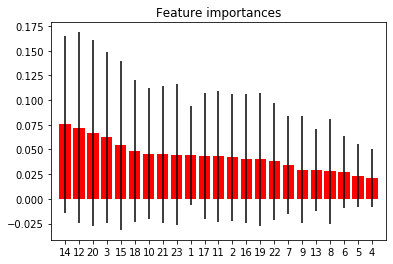

In [0]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

#get importances
importances = rf.feature_importances_


std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1] # invert sorted array

# Print the feature rank
print("Feature ranking:")

for f in range(trainX.shape[1]):
    print("{}. feature {} ({})" .format(f + 1, indices[f]+1, importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(trainX.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(trainX.shape[1]), indices+1)
plt.xlim([-1, trainX.shape[1]])
plt.show()



#Optional  - fine tune RF paramters - note that it is worth trying default values too , as not all combinations are tested in the fine tune . Note that fine tune for random selection of training data may not be the same when applied to all data combined

In [0]:


import sklearn.ensemble  
import sklearn.metrics  
from sklearn.model_selection import GridSearchCV
 


rftune = sklearn.ensemble.RandomForestClassifier()  

param_grid = {  
           "n_estimators" : [5, 10, 100,500, 1000],  
           "max_features" : ["auto", "sqrt", "log2", 2,3,4,10], #add more parameters here if required - but this will increase time to run
           "random_state" : [99]
           }  

flattrainy = np.ndarray.flatten(trainy)
CV_rf = GridSearchCV(estimator=rftune, param_grid=param_grid)  
CV_rf.fit(trainX, flattrainy)  
print(CV_rf.best_params_)  

{'max_features': 10, 'n_estimators': 500, 'random_state': 99}


KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2, metric = 'minkowski', p = 2)
knn.fit(trainX, trainy)
pred_y = knn.predict(testX)
cm = confusion_matrix(testy, pred_y)
acc = accuracy_score(testy, pred_y)
f1 = f1_score(testy, pred_y, average=None)
print ("KNN:\n{0}\nOverall: {1}%\nF1: {2}".format(cm,round(acc*100, 3),(f1)))


KNN:
[[64  0  0  0  0]
 [ 1 67  1  6  0]
 [ 0  2 61  0  0]
 [ 0  1  0 61  0]
 [ 0  0  1  2 59]]
Overall: 95.706%
F1: [0.99224806 0.92413793 0.96825397 0.93129771 0.97520661]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(random_state = 99, max_iter=5000)
lgr.fit(trainX, trainy)
pred_y = lgr.predict(testX)
cm = confusion_matrix(testy, pred_y)
acc = accuracy_score(testy, pred_y)
f1 = f1_score(testy, pred_y, average=None)
print ("logistic regression:\n{0}\nOverall: {1}%\nF1: {2}".format(cm,round(acc*100, 3),(f1)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


logistic regression:
[[64  0  0  0  0]
 [ 2 61  1 11  0]
 [ 0  0 63  0  0]
 [ 0  7  0 55  0]
 [ 0  0  0  1 61]]
Overall: 93.252%
F1: [0.98461538 0.85314685 0.99212598 0.85271318 0.99186992]


XG Boost

In [0]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(trainX, trainy)
pred_y = xg.predict(testX)
cm = confusion_matrix(testy, pred_y)
acc = accuracy_score(testy, pred_y)
f1 = f1_score(testy, pred_y,average=None)
print ("XGBoost:\n{0}\nOverall: {1}%\nF1: {2}".format(cm,round(acc*100, 3),(f1)))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBoost:
[[64  0  0  0  0]
 [ 2 69  1  3  0]
 [ 0  0 63  0  0]
 [ 0  3  0 59  0]
 [ 0  0  0  2 60]]
Overall: 96.626%
F1: [0.98461538 0.93877551 0.99212598 0.93650794 0.98360656]


Linear Discriminant Analysis

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
ld = LDA()
ld.fit(trainX, trainy)
pred_y = ld.predict(testX)
cm = confusion_matrix(testy, pred_y)
acc = accuracy_score(testy, pred_y)
f1 = f1_score(testy, pred_y, average=None)
print ("LDA:\n{0}\nOverall: {1}%\nF1: {2}".format(cm,round(acc*100, 3),(f1)))

LDA:
[[60  2  0  2  0]
 [ 4 56  1 14  0]
 [ 0  1 62  0  0]
 [ 0 30  0 32  0]
 [ 2  0  0  1 59]]
Overall: 82.515%
F1: [0.92307692 0.68292683 0.98412698 0.57657658 0.97520661]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Ensemble classifier - try different combinations of models to try and get zero error on class of interest (bare peat is class 10, first row/ column) - it may be possible to 'balance' errors out eg if one model has class 10 ommission error and another has class 10 commission error for the problematic class - usually 20)

In [0]:
from sklearn.ensemble import VotingClassifier
#voting_clf = VotingClassifier(estimators=[('lr', lgr),('rf', rf),('knn',knn),('xg',xg)],voting='soft')#voting='hard'
voting_clf = VotingClassifier(estimators=[('rf',rf) ,('knn',knn)],voting='soft')#voting='hard'
voting_clf.fit(trainX, trainy)
pred_y = voting_clf.predict(testX)
cm = confusion_matrix(testy, pred_y)
acc = accuracy_score(testy, pred_y)
f1 = f1_score(testy, pred_y, average=None)
print ("Ensemble:\n{0}\nOverall: {1}%\nF1: {2}".format(cm,round(acc*100, 3),(f1)))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Ensemble:
[[64  0  0  0  0]
 [ 1 67  1  6  0]
 [ 0  1 62  0  0]
 [ 0  1  0 61  0]
 [ 0  0  1  1 60]]
Overall: 96.319%
F1: [0.99224806 0.93055556 0.97637795 0.93846154 0.98360656]


Optional - run on all data

In [0]:

alltrainX = np.append(testX, trainX, axis = 0)
alltrainy = np.append(testy, trainy, axis = 0)
alltrainy = np.ndarray.flatten(alltrainy)
#knn.fit(alltrainX, alltrainy)
#rf.fit(alltrainX, alltrainy)


voting_clf.fit(alltrainX, alltrainy)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=2,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
             

Output probability image - this stage takes longer for ensemble classifier and time may also depend on parameters of random forest 

In [0]:


#Select model of choice
model = voting_clf #xg, rf, knn, lgr ,voting_clf



##NOTE - unable to predict probability for ensemble classifer when voting = hard.
##NOTE - knn probability output only has a few categories
s2prof.update(count=1, nodata=None, dtype=np.float32)
dst = rasterio.open(os.path.join(image_dir,'{}_RF_KNN_alldata1000trees.tif'.format(iteration)), 'w', **s2prof)

for block_index, window in s2.block_windows(1):
    s2_block = s2.read(window=window, masked=True)
    ######################################################################################
    #SELECTION OF BANDS##########################################
    # delete the band that needs excluding (band number minus 1, eg darkness is index 13)
    #s2_block = np.delete(s2_block,13, 0)
    ################################################################################
    v= s2_block.shape
    s2_block = s2_block.reshape(B, -1).T
    s2_block = sc.transform(s2_block)
    s2_block[s2_block<-3.4e+35]=9999
    result_block = model.predict_proba(s2_block).astype('float32')
    #select probabilies for class 1 only
    result_block = result_block[:,0]
    result_block = result_block.reshape(1,v[1],v[2])
    dst.write(result_block, window=window)
dst.close()